Subtask B: Verifiable factual claims detection: Given a tweet, predict whether it contains a verifiable factual claim. This is a binary task with two labels: Yes and No. This is a classification task

In [35]:
import pandas as pd
import numpy as np
import json
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy

import warnings
warnings.filterwarnings("ignore")

# Load Lemmatizer
nlp = spacy.load("en_core_web_sm")

# Load Stopwords
nltk.download('stopwords')
cachedStopWords = list(set(stopwords.words("english")))



# a)
# Twitter Datasets
df_worthy_train = pd.read_csv("data/1b/CT22_english_1B_claim_train.tsv", sep='\t')
df_worthy_test = pd.read_csv("data/1b/CT22_english_1B_claim_dev_test.tsv", sep='\t')

# Top 3000 most commonly used english words + covid related medical terms (used as vocabulary for the vectorization process)
topwords = pd.read_csv('words.txt', sep=" ", header=None).values[:,0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Emoji Removal

In [36]:
# Function to remove emojies when using the lemmatizer
#https://poopcode.com/how-to-remove-emoji-from-text-in-python/
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

### Custom Tokenizer

In [37]:
def tokenize_text(text, method="stopwords"):
    
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)
    
    # Split sentence into words
    tokens = []
    for token in ngrams(text.split(), 1):
        word = re.sub(r',', '', token[0]) #Remove commas
        word = re.sub(r'[\!\.\:]$', '', word) #Remove (.!:) at the end of tokens
        word = re.sub(r'#', '', word) #Remove hashtags (not the text)
        if word == "—": continue #Ignore dash
        if word.find("@") != -1: continue #Ignore tags
        tokens.append(word)
    tokens

    # List comprehension to remove stopwords
    if method != "default":
        tokens = [x for x in tokens if x not in cachedStopWords]

    # Perform stemming
    if method == "stemming":
        ps = PorterStemmer()
        tokens = [ps.stem(x) for x in tokens]

    # Perform lemmatization
    if method == "lemmatizer":
        # Remove emojies due to lemmatizer not handling them well
        tokens = [x for x in tokens if remove_emoji(x) != ""]
        text = " ".join(tokens)
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]

    return tokens

In [38]:
def tokenize_normal(text):
    return tokenize_text(text, method="default")

def tokenize_stopwords(text):
    return tokenize_text(text, method="stopwords")

def tokenize_stemming(text):
    return tokenize_text(text, method="stemming")

def tokenize_lemmatizer(text):
    return tokenize_text(text, method="lemmatizer")

In [39]:
def tokenize_df(df, text_col, method="default"):
    article_tokens = []
    for i in range(len(df)):
        text = df.iloc[i][text_col].lower()
        article_tokens.append(tokenize_text(text, method))
    df["tokens"] = article_tokens

In [40]:
tokenize_df(df_worthy_train, "tweet_text", "lemmatizer")
tokenize_df(df_worthy_test, "tweet_text", "lemmatizer")

In [41]:
print(df_worthy_train["tokens"][0], "\n")
print(df_worthy_test["tokens"][0])

['india', "'s", 'gift', '100000', 'covid-19', 'vaccine', 'arrive', 'barbado', 'early', 'today', 'special', 'moment', 'barbadian', 'want', 'thank', 'prime', 'minister', 'modi', 'quick', 'decisive', 'magnanimous', 'action', 'allow', 'we', 'beneficiary', 'vaccine'] 

['senate', 'pass', 'covid', 'relief', '$', '1400', 'relief', 'check', 'fund', 'vaccine', 'money', 'reopen', 'school', 'food', 'unemployment', 'rental', 'assistance', 'cut', 'child', 'poverty', 'half', 'help', 'small', 'business', 'must', 'end', 'pandemic', 'help', 'way']


### Bag of words

In [73]:
from sklearn.feature_extraction.text import CountVectorizer # For creating a DTM (discrete values)
from sklearn.feature_extraction.text import TfidfVectorizer # A weighted DTM (fractions)

cv_dict = {}
tfidf_dict = {}
ngram_list = [1,2,3]
for n in ngram_list:
    cv_dict[n] = CountVectorizer(tokenizer=tokenize_lemmatizer, ngram_range=(n, n), max_features=5000)
    tfidf_dict[n] = TfidfVectorizer(tokenizer=tokenize_stopwords, ngram_range=(n, n), max_features=5000)
#cv = CountVectorizer(tokenizer=tokenize_lemmatizer, ngram_range=(1, 1), max_features=5000) #Test with different n-grams, min_df, max_df and max_features
#tfidf = TfidfVectorizer(tokenizer=tokenize_stopwords, ngram_range=(1, 1), max_features=5000) #Test with (1,1), (2,2), and (3,3) 

In [54]:
tweet_vec = {}
tweet_bow_train = {}
tweet_bow_test = {}
for n in ngram_list:
    tweet_vec[n] = cv_dict[n].fit(df_worthy_train["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train[n] = tweet_vec[n].transform(df_worthy_train["tweet_text"]) 
    tweet_bow_test[n] = tweet_vec[n].transform(df_worthy_test["tweet_text"]) 

### Feature Exploration

In [74]:
# If max_features not limited, there are 8263 unique words (features) and a total of 51243 words across 2123 tweets
for n in ngram_list:
    captured = tweet_bow_train[n].sum()
    print(f"Total words across all tweets: 51243")
    print(f"Total words captured by our features/vocabulary {captured} ({round(100*captured/51243, 1)}%)")
    print(f"Amount of unique words (tokens/features): {len(tweet_vec[n].vocabulary_)}\n") # Unique words (features)

    # vec.vocabulary_items() => Dict with every word in the vocabulary with the DTM column index as the value
    sum_words = tweet_bow_train[n].sum(axis=0) # Sum the columns from the DTM matrix
    words_freq = [(word, sum_words[0, index]) for word, index in tweet_vec[n].vocabulary_.items()] # Make a list pairing every word with its corresponding DTM column summation
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    print("Most frequent terms for {}-gram: \n {}".format(n, words_freq[:10])) # show top n terms used

Total words across all tweets: 51243
Total words captured by our features/vocabulary 67556 (131.8%)
Amount of unique words (tokens/features): 5000

Most frequent terms for 1-gram: 
 [('vaccine', 3856), ('covid-19', 2047), ('-', 966), ('"', 591), ('get', 558), ('covid', 491), ('people', 404), ('covid19', 372), (';', 351), ('we', 347)]
Total words across all tweets: 51243
Total words captured by our features/vocabulary 22976 (44.8%)
Amount of unique words (tokens/features): 5000

Most frequent terms for 2-gram: 
 [('covid-19 vaccine', 1250), ('& amp', 294), ('amp ;', 294), ('covid vaccine', 246), ('covid19 vaccine', 141), ('covid-19 vaccines', 103), ('. "', 100), ('safe effective', 89), ('coronavirus vaccine', 79), ('get vaccine', 72)]
Total words across all tweets: 51243
Total words captured by our features/vocabulary 9938 (19.4%)
Amount of unique words (tokens/features): 5000

Most frequent terms for 3-gram: 
 [('& amp ;', 294), ('johnson & amp', 56), ('amp ; johnson', 56), ('dose covi

### Dummy Predictions

In [75]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

for n in ngram_list:
    dummy_clf = DummyClassifier(strategy="prior")
    dummy_clf.fit(tweet_bow_train[n], df_worthy_train["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf.class_prior_))

    accuracy_score = metrics.accuracy_score(dummy_clf.predict(tweet_bow_test[n]), df_worthy_test["class_label"])
    print("Dummy Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(dummy_clf.predict(tweet_bow_test[n]), df_worthy_test["class_label"])
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    print("--------------------------------------")

1-gram Priors: [0.36161252 0.63838748]
Dummy Accuracy for 1-gram: 63.01%
Dummy F1-Score for 1-gram: 77.31%
--------------------------------------
2-gram Priors: [0.36161252 0.63838748]
Dummy Accuracy for 2-gram: 63.01%
Dummy F1-Score for 2-gram: 77.31%
--------------------------------------
3-gram Priors: [0.36161252 0.63838748]
Dummy Accuracy for 3-gram: 63.01%
Dummy F1-Score for 3-gram: 77.31%
--------------------------------------


### Naive Bayes Prediction

In [77]:

#https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes
from sklearn.naive_bayes import MultinomialNB # suited for classification with discrete features
from sklearn.naive_bayes import ComplementNB # suited for imbalanced datasets (designed to correct for "severe assumptions")
from sklearn.naive_bayes import BernoulliNB # designed for classification with binary/boolean features
from sklearn.naive_bayes import GaussianNB # designed for classification with continuous values

clf = ComplementNB()
for n in ngram_list:
    clf.fit(tweet_bow_train[n].toarray(), df_worthy_train["class_label"])

    accuracy_score = metrics.accuracy_score(clf.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"])
    print("Complement Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    accuracy_score = metrics.f1_score(clf.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"])
    print("Complement F1-Score for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))
    print("--------------------------------------")

Complement Accuracy for 1-gram: 72.56%
Complement F1-Score for 1-gram: 77.56%
--------------------------------------
Complement Accuracy for 2-gram: 64.11%
Complement F1-Score for 2-gram: 69.41%
--------------------------------------
Complement Accuracy for 3-gram: 52.8%
Complement F1-Score for 3-gram: 53.66%
--------------------------------------


### SVD

In [13]:
import numpy as np
from scipy.linalg import svd

In [99]:

mat = tweet_bow_train[1].toarray()
X = mat-mat.mean()  
X = np.array(X)
np.shape(X)


(3324, 5000)

In [100]:
cov_matrix = np.cov(X.T)
np.shape(cov_matrix)

(5000, 5000)

In [101]:
def getSVD(cov_matrix):
    #TODO user np.linalg.svd here
    U, S, V = svd(cov_matrix)
    return U, S, V

In [102]:
U, S, V = getSVD(cov_matrix)

In [103]:
np.shape(U)

(5000, 5000)

In [104]:
def getKComponents(U, X, K):
       # implement matrix multiplication of first k columns of U * X
       U_col = U[:,0:K]
       return np.matmul(X,U_col)

In [105]:
k = 1000
z = getKComponents(U, X, k)
np.shape(z)

(3324, 1000)

### PCA

In [106]:
def getVarianceRatio(Z, U, X, K):
    #Implement computation of reconstruction error
    X_hat = np.matmul(Z,U[:, :K].T)
    ratio = np.mean((X-X_hat).T.dot(X-X_hat))/np.mean(X.T.dot(X))
    return ratio

In [107]:
ratio = getVarianceRatio(z, U, X, k)
ratio

2.816247877165452

### Plot

In [108]:
import matplotlib.pyplot as plt

def plotFunction(PCA, Y):
    labels = Y.values
    
    
    X_val = PCA[:,:2]

    plt.scatter(X_val[:,0], X_val[:,1],c=labels ,alpha=0.5)
    plt.show()

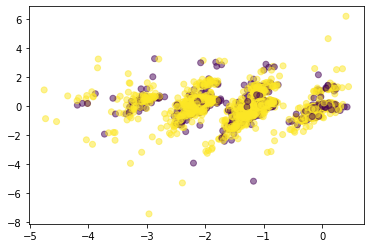

In [109]:
plotFunction(z, df_worthy_train["class_label"])

### Best K

In [110]:
def findBestK(initial, step):
    #TODO use the getVarianceRatio to find the best K
    ratio = np.inf
    while ratio > 0.001:
        initial += step
        z = getKComponents(U, X, initial)
        ratio = getVarianceRatio(z, U, X, initial)
    return initial

In [111]:
step = 543
initial = 1
optimalK = findBestK(initial, step)
optimalK

4888

In [112]:
z = getKComponents(U, X, optimalK)

### TSNE

In [113]:
from sklearn.manifold import TSNE
tsne_pca_results = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(z)

In [114]:
tsne_pca_results

array([[ 2.836089  , -0.77582866],
       [ 4.83741   ,  1.0106502 ],
       [-2.6075435 ,  6.574304  ],
       ...,
       [ 1.3968722 ,  6.2740173 ],
       [-3.8506477 , -0.5682905 ],
       [-1.7867159 , -0.11576127]], dtype=float32)

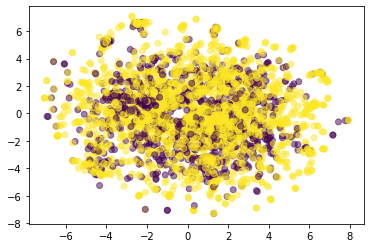

In [115]:
plotFunction(tsne_pca_results, df_worthy_train["class_label"])